In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

## A. Load Masks and Prediction

In [2]:
segmentation_path = '/Users/beatrizfernandes/PIC2/tasks instantdl/nuclei2d_instance_segmentation/aftk7_2/'
results_path = segmentation_path + 'results/'
path_auxiliary = '/Users/beatrizfernandes/Documents/Biomédica@IST/Mestrado/PIC2/auxiliary/'
image_id = os.listdir(results_path)[0].split('.')[0]
image_id

'image_011_nuclei2d'

In [141]:
prediction = np.load(results_path + image_id + '.npy')
prediction.shape

(1024, 1024, 127)

In [142]:
masks_path = segmentation_path + 'test/' + image_id + '/mask/'
len(os.listdir(masks_path))

167

In [143]:
mask = np.zeros((1024, 1024, len(os.listdir(masks_path))))
for m, msk in enumerate(os.listdir(masks_path)):
    mask[:, :, m] = plt.imread(masks_path + msk)
mask.shape

(1024, 1024, 167)

## B. Visualize Mask and Prediction

In [144]:
prediction_2d = np.zeros(prediction.shape[0:2])
mask_2d = np.zeros(mask.shape[0:2])
for i in np.arange(prediction.shape[2]):
    prediction_2d += prediction[:,:,i]*i

for i in np.arange(mask.shape[2]):
    mask_2d += mask[:,:,i]*i

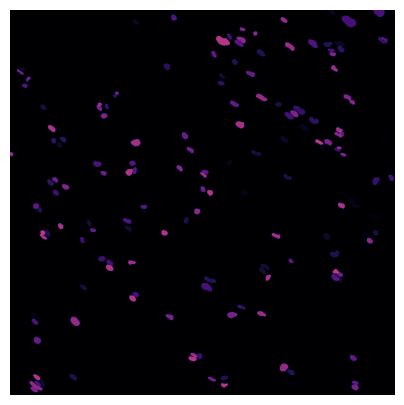

In [160]:
plt.figure(figsize=(5,5))
plt.imshow(mask_2d, cmap='magma')
plt.axis('off')
plt.savefig('intance segmentation.png', dpi = 600)
plt.show()


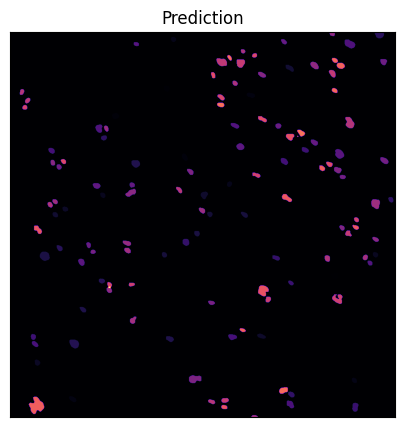

In [166]:
plt.figure(figsize=(5,5))
plt.imshow(prediction_2d, cmap='magma')
plt.title('Prediction')
plt.tick_params(left = False, bottom = False, labelbottom = False, labelleft=False)
plt.savefig(path_auxiliary + "pred011.png", dpi = 600)
plt.show()

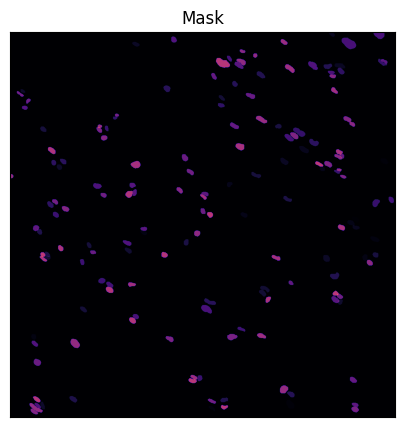

In [165]:
plt.figure(figsize=(5,5))
plt.imshow(mask_2d, cmap='magma')
plt.title('Mask')
plt.tick_params(left = False, bottom = False, labelbottom = False, labelleft=False)
plt.savefig(path_auxiliary + "groundtruth011.png", dpi = 600)
plt.show()

## C. Jaccard similarity, TP, FP, FN

The true positive rate (TPR, also called sensitivity) is the probability that an actual positive will test positive. 

$TPR = \frac{TP}{TP+FN}$

The false negative rate — also called the miss rate — is the probability that a true positive will be missed by the test.

$FNR = \frac{FN}{FN+TP}$

Positive predicted value:

$PPV = \frac{TP}{TP+FP}$

In [5]:
model_name = "ftk7_1"
path_metrics = "/Users/beatrizfernandes/PIC2/tasks instantdl/nuclei2d_instance_segmentation/{}/metrics/".format(model_name)
path_models = "/Users/beatrizfernandes/PIC2/tasks instantdl/nuclei2d_instance_segmentation/"
path_auxiliary = '/Users/beatrizfernandes/Documents/Biomédica@IST/Mestrado/PIC2/auxiliary/'

In [3]:
## FUNCTIONS
def ReLU(x, dev=0):
    return x * (x - dev > 0)

def conf_matrix(path_metrics):
    tp, fp, fn = [],[],[]
    partide_mask, partide_prediction = [],[]
    mean_iou = []
    mds = []

    partide_mask_dict, partide_prediction_dict = dict(), dict()


    for md in list(filter(lambda element: 'iou' in element, os.listdir(path_metrics))):
        mds.append('_'.join(md.split('.')[0].split('_')[2:]))
        iou = pd.read_csv(''.join([path_metrics,md]), index_col=0)

        # Only counts as a prediction if the IoU is above 0.2
        thresholded_iou = ReLU(iou, dev = 0.2)
        binary_msk = np.sign(np.sign(thresholded_iou).sum(axis=0))
        binary_pred = np.sign(np.sign(thresholded_iou).sum(axis=1))

        nan_thresholded_iou = ReLU(pd.read_csv(''.join([path_metrics,md]), index_col=0),0.2)
        nan_thresholded_iou[nan_thresholded_iou ==0] = np.nan
        mean_iou.append(np.nanmean(np.array(nan_thresholded_iou).flatten()))

        if 0 in binary_msk.values:
            fn.append(binary_msk.value_counts()[0])
        else: fn.append(0)

        if 0 in binary_pred.values:
            fp.append(binary_pred.value_counts()[0])
        else: fp.append(0)

        # True positives defined as masks that have only one prediction
        # if 1 in np.sign(iou).sum(axis=0).values:
        #     total_tp = np.sign(iou).sum(axis=0).value_counts()[1]
        # else: total_tp = 0
        # tp.append(total_tp)

        # True positives defined as masks that have any prediction
        if 1 in np.sign(np.sign(iou).sum(axis=0)).values:
            total_tp = np.sign(np.sign(iou).sum(axis=0)).value_counts()[1]
        else: total_tp = 0
        tp.append(total_tp)

        # Count masks with more than one prediction
        check_mask = np.sign(thresholded_iou).sum(axis=0).value_counts().drop([i for i in [0,1] if i in np.sign(thresholded_iou).sum(axis=0).values])
        # if check_mask.empty:
        #     partide_mask.append(0)
        # else: partide_mask.append([check_mask])

        for p in check_mask.index:
            if p in partide_mask_dict.keys(): partide_mask_dict[p] += check_mask[p]
            else: partide_mask_dict[p] = check_mask[p]

        # Count predictions in more than one mask
        check_pred = np.sign(thresholded_iou).sum(axis=1).value_counts().drop([i for i in [0,1] if i in np.sign(thresholded_iou).sum(axis=1).values])
        # if check_pred.empty:
        #     partide_prediction.append(0)
        # else: partide_prediction.append([check_pred])

        for p in check_pred.index:
            if p in partide_prediction_dict.keys(): partide_prediction_dict[p] += check_pred[p]
            else: partide_prediction_dict[p] = check_pred[p]

        # if 1 in binary_pred.values:
        #     tp.append(binary_pred.value_counts()[1:].sum())
        # else: tp.append(0)

    return mds, tp, fp, fn, mean_iou, partide_mask_dict, partide_prediction_dict

In [11]:
image_ids = list(filter(lambda element: 'DS_Store' not in element, os.listdir("/Users/beatrizfernandes/PIC2/data/preprocessing_auto/layer 3/2d instance masks")))
list_models = list(filter(lambda element: '.DS_Store' not in element, os.listdir(path_models)))
model_types = set([i.split('_')[0] for i in list_models])

total_confusion = pd.DataFrame(np.zeros((3, len(model_types))), columns=sorted(list(model_types)), index=['TP', 'FP', 'FN'])
summary = dict()

for type in model_types:
    summary[type] = {'metrics': pd.DataFrame(np.zeros((21, 7)), columns=['TP', 'FP', 'FN', 'IoU', 'Prediction', 'Ground Truth', 'Ratio'], index = image_ids),
                     'partide_prediction': dict(),
                     'partide_mask': dict(),
                     'total_confusion': dict(),
                     'counts': dict()}
    for el_type in list(filter(lambda element: element.split('_')[0] == type, list_models)):
        mds, tp, fp, fn, iou, partide_mask, partide_prediction = conf_matrix("{}{}/metrics/".format(path_models,el_type))
        counts = pd.read_csv("{}{}/metrics/counts.csv".format(path_models,el_type), index_col=1)
        # print("tp: {} - fp: {} -  fn: {} - iou: {} - partide_mask: {} - partide_prediction: {}".format(tp, fp, fn, np.round(iou,2), partide_mask, partide_prediction))
        total_confusion[type] += np.array([sum(tp), sum(fp), sum(fn)])
        summary[type]['metrics'].loc[mds, ['TP', 'FP', 'FN', 'IoU']] = np.array([tp, fp, fn, iou]).T
        summary[type]['metrics'].loc[mds, ['Prediction', 'Ground Truth', 'Ratio']] = np.array(counts.loc[mds, ['Pred', '# Masks', 'Ratio']])
        summary[type]['partide_prediction'] = (partide_prediction, sum(partide_prediction.values()), sum(partide_prediction.values())/sum(summary[type]['metrics']['TP']))
        summary[type]['partide_mask'] = (partide_mask, sum(partide_mask.values()))
    summary[type]['total_confusion']['TP'] = sum(summary[type]['metrics']['TP'])
    summary[type]['total_confusion']['FP'] = sum(summary[type]['metrics']['FP'])
    summary[type]['total_confusion']['FN'] = sum(summary[type]['metrics']['FN'])
    summary[type]['total_confusion']['TPR'] = sum(summary[type]['metrics']['TP'])/(sum(summary[type]['metrics']['TP'])+sum(summary[type]['metrics']['FN']))
    summary[type]['total_confusion']['FNR'] = sum(summary[type]['metrics']['FN'])/(sum(summary[type]['metrics']['TP'])+sum(summary[type]['metrics']['FN']))
    summary[type]['total_confusion']['PPV'] = sum(summary[type]['metrics']['TP'])/(sum(summary[type]['metrics']['TP'])+sum(summary[type]['metrics']['FP']))
    summary[type]['total_confusion']['AP'] = sum(summary[type]['metrics']['TP'])/(sum(summary[type]['metrics']['TP'])+sum(summary[type]['metrics']['FP'])+sum(summary[type]['metrics']['FN']))
    summary[type]['counts']['predictions'] = sum(summary[type]['metrics']['Prediction'])
    summary[type]['counts']['ground truth'] = sum(summary[type]['metrics']['Ground Truth'])
    summary[type]['counts']['mean ratio'] = summary[type]['metrics']['Ratio'].mean()
    summary[type]['counts']['mean iou'] = summary[type]['metrics']['IoU'].mean()

# total_confusion.loc['TPR'] =  total_confusion.loc['TP']/(total_confusion.loc['TP'] + total_confusion.loc['FN'])
# total_confusion.loc['FNR'] =  total_confusion.loc['FN']/(total_confusion.loc['TP'] + total_confusion.loc['FN'])
# total_confusion.loc['PPV'] =  total_confusion.loc['TP']/(total_confusion.loc['TP'] + total_confusion.loc['FP'])

# total_confusion

/var/folders/p1/6g8qw2ls3v7cq5v7dd31td5m0000gq/T/ipykernel_999/1763859856.py:25: RuntimeWarning: Mean of empty slice
  mean_iou.append(np.nanmean(np.array(nan_thresholded_iou).flatten()))
/var/folders/p1/6g8qw2ls3v7cq5v7dd31td5m0000gq/T/ipykernel_999/1763859856.py:25: RuntimeWarning: Mean of empty slice
  mean_iou.append(np.nanmean(np.array(nan_thresholded_iou).flatten()))
/var/folders/p1/6g8qw2ls3v7cq5v7dd31td5m0000gq/T/ipykernel_999/1763859856.py:25: RuntimeWarning: Mean of empty slice
  mean_iou.append(np.nanmean(np.array(nan_thresholded_iou).flatten()))
/var/folders/p1/6g8qw2ls3v7cq5v7dd31td5m0000gq/T/ipykernel_999/1763859856.py:25: RuntimeWarning: Mean of empty slice
  mean_iou.append(np.nanmean(np.array(nan_thresholded_iou).flatten()))
/var/folders/p1/6g8qw2ls3v7cq5v7dd31td5m0000gq/T/ipykernel_999/1763859856.py:25: RuntimeWarning: Mean of empty slice
  mean_iou.append(np.nanmean(np.array(nan_thresholded_iou).flatten()))
/var/folders/p1/6g8qw2ls3v7cq5v7dd31td5m0000gq/T/ipykernel_9

In [7]:
summary['cellpose']

{'metrics':                        TP      FP    FN       IoU  Prediction  Ground Truth  \
 image_004_nuclei2d   69.0     4.0  16.0  0.405875        52.0          69.0   
 image_005_nuclei2d   87.0     6.0  32.0  0.491636        59.0          90.0   
 image_019_nuclei2d    6.0     0.0  45.0  0.631155         6.0          51.0   
 image_018_nuclei2d   63.0     2.0  14.0  0.674445        58.0          73.0   
 image_013_nuclei2d  167.0     1.0  31.0  0.683432       143.0         194.0   
 image_012_nuclei2d  117.0     1.0  38.0  0.609752        91.0         148.0   
 image_020_nuclei2d   51.0  1330.0   9.0  0.561578      1382.0          59.0   
 image_021_nuclei2d   57.0    15.0  31.0  0.501508        47.0          63.0   
 image_014_nuclei2d  101.0     0.0   8.0  0.586946        78.0         104.0   
 image_015_nuclei2d   91.0     8.0  15.0  0.648636        91.0         100.0   
 image_009_nuclei2d   44.0     1.0  25.0  0.712842        42.0          68.0   
 image_008_nuclei2d   73.0   

In [8]:
list(summary.keys())

['dsb2018',
 'imagenet',
 'aftk7',
 'ftk7',
 'stardist',
 'aftk3',
 'cellpose',
 'ftk3']

In [15]:
rep = ['TPR', 'PPV', 'AP', 'mean IoU', 'mean Ratio', 'Aggregated predictions (%)']
report = pd.DataFrame(np.zeros((len(list(summary.keys())), len(rep))), index=['imagenet', 'dsb2018', 'ftk3', 'ftk7', 'aftk3', 'aftk7', 'stardist', 'cellpose'], columns = rep)

for model in summary.keys():
    report.loc[model] = np.round(np.array([summary[model]['total_confusion']['TPR'], 
                                           summary[model]['total_confusion']['PPV'],
                                           summary[model]['total_confusion']['AP'],
                                           summary[model]['counts']['mean iou'],
                                           summary[model]['counts']['mean ratio'],
                                           summary[model]['partide_prediction'][2]])*100, 2)

report

,TPR,PPV,AP,mean IoU,mean Ratio,Aggregated predictions (%)
imagenet,20.69,13.32,8.82,26.64,214.71,0.82
dsb2018,47.24,79.13,42.01,41.65,52.37,16.28
ftk3,89.91,94.02,85.04,62.72,88.12,4.65
ftk7,83.53,95.62,80.45,63.62,80.19,2.70
aftk3,85.10,94.13,80.81,63.50,85.42,5.14
aftk7,84.60,95.69,81.49,63.80,82.15,2.58
stardist,88.08,85.78,76.86,64.83,108.53,4.85
cellpose,79.12,26.90,25.12,58.73,468.43,7.46


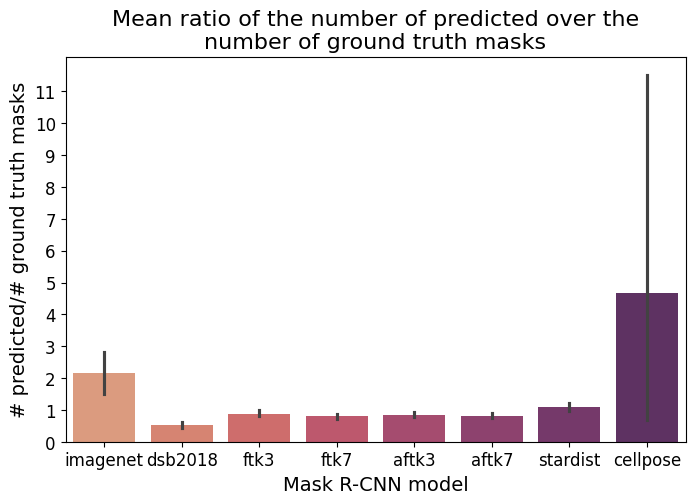

In [175]:
models = ['imagenet', 'dsb2018', 'ftk3', 'ftk7', 'aftk3', 'aftk7', 'stardist', 'cellpose']
data = np.array([summary[key]['metrics']['Ratio'] for key in models]).T
plt.figure(figsize=(8,5))
sns.barplot(data, palette='flare')
plt.xticks(ticks=np.arange(len(models)), labels=models, fontsize = 12)
plt.yticks(ticks = np.arange(12), fontsize = 12)
plt.xlabel('Mask R-CNN model', fontsize = 14)
plt.ylabel('# predicted/# ground truth masks', fontsize = 14)
plt.title('Mean ratio of the number of predicted over the\nnumber of ground truth masks', fontsize = 16)
plt.savefig(path_auxiliary + 'ratio.png', dpi = 600)
plt.show()

# for key in summary.keys():
#     ratio = summary[key]['metrics']['Ratio']
#     sns.boxplot(ratio)
#     print(ratio)

In [136]:
summary['dsb2018']['metrics'].corr(method='spearman')

,TP,FP,FN,IoU,Prediction,Ground Truth,Ratio
TP,1.000000,-0.817686,-0.044228,0.066813,0.282552,0.524228,-0.256261
FP,-0.817686,1.000000,0.333340,-0.453115,-0.232257,-0.257522,0.002614
FN,-0.044228,0.333340,1.000000,-0.638596,0.379591,0.727273,-0.762338
IoU,0.066813,-0.453115,-0.638596,1.000000,-0.372257,-0.326316,0.321053
Prediction,0.282552,-0.232257,0.379591,-0.372257,1.000000,0.520637,-0.045499
Ground Truth,0.524228,-0.257522,0.727273,-0.326316,0.520637,1.000000,-0.766234
Ratio,-0.256261,0.002614,-0.762338,0.321053,-0.045499,-0.766234,1.000000


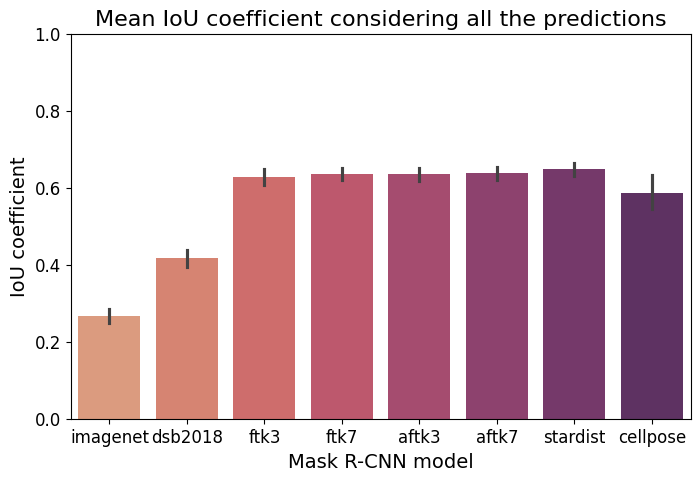

In [10]:
models = ['imagenet', 'dsb2018', 'ftk3', 'ftk7', 'aftk3', 'aftk7', 'stardist', 'cellpose']
data = np.array([summary[key]['metrics']['IoU'] for key in models]).T
plt.figure(figsize=(8,5))
sns.barplot(data, estimator='mean', palette='flare')
plt.xticks(ticks=np.arange(len(models)), labels=models, fontsize = 12)
plt.ylim((0,1))
plt.yticks(fontsize = 12)
plt.xlabel('Mask R-CNN model', fontsize = 14)
plt.ylabel('IoU coefficient', fontsize = 14)
plt.title('Mean IoU coefficient considering all the predictions', fontsize = 16)
plt.savefig(path_auxiliary + 'iou coefficient.png', dpi = 600)
plt.show()

In [67]:
l2 = 0
t = 0

for ds in list(filter(lambda element: 'iou' in element, os.listdir("/Users/beatrizfernandes/PIC2/tasks instantdl/nuclei2d_instance_segmentation/imagenet/metrics/"))):
    iou = pd.read_csv("/Users/beatrizfernandes/PIC2/tasks instantdl/nuclei2d_instance_segmentation/imagenet/metrics/{}".format(ds), index_col=0)
    l2 += np.sign(iou[iou <= 0.2]).sum().sum()
    t += np.sign(iou[iou >0]).sum().sum()

l2,t, l2/t

(1259.0, 1352.0, 0.9312130177514792)

In [20]:
l2 = 0
t = 0

for ds in list(filter(lambda element: 'iou' in element, os.listdir("/Users/beatrizfernandes/PIC2/tasks instantdl/nuclei2d_instance_segmentation/noft/metrics/"))):
    iou = pd.read_csv("/Users/beatrizfernandes/PIC2/tasks instantdl/nuclei2d_instance_segmentation/noft/metrics/{}".format(ds), index_col=0)
    l2 += iou[iou > 0.2].sum().sum()
    t += np.sign(iou[iou > 0.2]).sum().sum()

l2,t, l2/t

(350.2186704136321, 821.0, 0.42657572522975895)

## D. Validation

In [108]:
rep = ['TPR', 'PPV', 'mean IoU', 'mean Ratio', 'Aggregated predictions (%)']
report = pd.DataFrame(np.zeros((3, len(rep))), index=['aftk7', 'stardist', 'cellpose'], columns = rep)

for model in ['aftk7', 'stardist', 'cellpose']:
    report.loc[model] = np.round(np.array([summary[model]['total_confusion']['TPR'], 
                                           summary[model]['total_confusion']['PPV'],
                                           summary[model]['counts']['mean iou'],
                                           summary[model]['counts']['mean ratio'],
                                           summary[model]['partide_prediction'][2]])*100, 2)

In [109]:
report

,TPR,PPV,mean IoU,mean Ratio,Aggregated predictions (%)
aftk7,84.60,95.69,63.80,82.15,2.58
stardist,88.08,85.78,64.83,108.53,4.85
cellpose,79.12,26.90,58.73,468.43,7.46


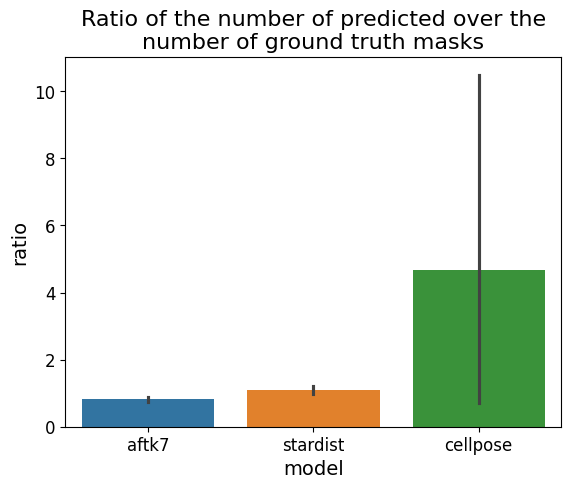

In [104]:
models = ['aftk7', 'stardist', 'cellpose']
data = np.array([summary[key]['metrics']['Ratio'] for key in models]).T
sns.barplot(data)
plt.xticks(ticks=np.arange(len(models)), labels=models, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('model', fontsize = 14)
plt.ylabel('ratio', fontsize = 14)
plt.title('Ratio of the number of predicted over the\nnumber of ground truth masks', fontsize = 16)
plt.show()

# for key in summary.keys():
#     ratio = summary[key]['metrics']['Ratio']
#     sns.boxplot(ratio)
#     print(ratio)

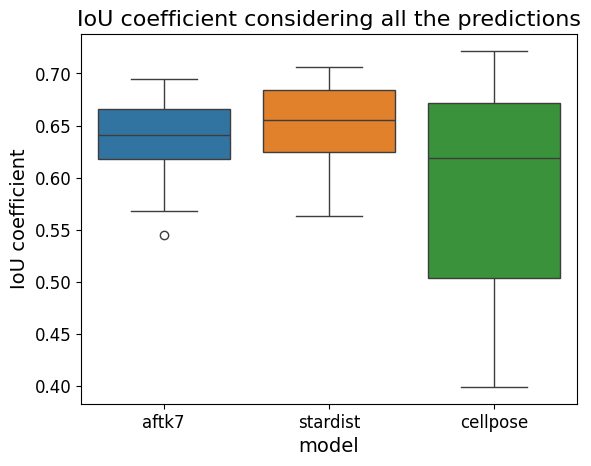

In [98]:
models = ['aftk7', 'stardist', 'cellpose']
data = np.array([summary[key]['metrics']['IoU'] for key in models]).T
sns.boxplot(data)
plt.xticks(ticks=np.arange(len(models)), labels=models, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('model', fontsize = 14)
plt.ylabel('IoU coefficient', fontsize = 14)
plt.title('IoU coefficient considering all the predictions', fontsize = 16)
plt.show()

In [106]:
summary['stardist']

{'metrics':                        TP    FP    FN       IoU  Prediction  Ground Truth  \
 image_004_nuclei2d   67.0   3.0   2.0  0.689190        68.0          69.0   
 image_005_nuclei2d   89.0   3.0   9.0  0.635351        75.0          90.0   
 image_019_nuclei2d   50.0  44.0   2.0  0.631083        96.0          51.0   
 image_018_nuclei2d   72.0  13.0   3.0  0.656842        85.0          73.0   
 image_013_nuclei2d  173.0  10.0  42.0  0.610595       156.0         194.0   
 image_012_nuclei2d  117.0   5.0  38.0  0.646476       108.0         148.0   
 image_020_nuclei2d   58.0  10.0   1.0  0.585176        75.0          59.0   
 image_021_nuclei2d   59.0  30.0   4.0  0.693181        90.0          63.0   
 image_014_nuclei2d   97.0  10.0  12.0  0.685275        93.0         104.0   
 image_015_nuclei2d   91.0  52.0  11.0  0.706270       141.0         100.0   
 image_009_nuclei2d   65.0   9.0   4.0  0.622217        78.0          68.0   
 image_008_nuclei2d   83.0  12.0   6.0  0.664020     